In [109]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import shap

from xgboost import XGBRegressor
from sklearn.feature_selection import f_regression, SelectKBest, RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from yellowbrick.regressor import PredictionError, ResidualsPlot

from env import get_db_url
import wrangle3


# California Dreamin' (of Beating the Zestimate)

<hr style="border-top: 10px groove maroon; margin-top: 1px; margin-bottom: 1px"></hr>

<img src="cali.webp" width="800" align="center">

<hr style="border-top: 10px groove maroon; margin-top: 1px; margin-bottom: 1px"></hr>

# Project Planning


- Acquire data from the Codeup Database and store the process as a function for replication. Save the function in a wrangle.py file to import into the Final Report Notebook.

- View data to gain understanding of the dataset and to create the readme.
    
- Create README.md with data dictionary, project and business goals, documentation of the initial hypotheses.
    
- Clean and prepare data for the first iteration through the data pipeline. Store this as a function to automate the process, store the function in the wrangle.py module, and prepare data in Final Report Notebook by importing and using the funtion.

- Clearly define at least two hypotheses, set an alpha, run the statistical tests needed, reject or fail to reject the Null Hypothesis, and document findings and takeaways.
   
- Establish a baseline accuracy and document well.

- Train four different regression models.
    
- Evaluate models on train and validate datasets.
    
- Choose the model with that performs the best and evaluate that single model on the test dataset.    

- Document executive summary, conclusions, takeaways, and next steps in the Final Report Notebook.

- Upload README.md, Data Dictionary, wrangle.py, Project Scratch Notebook, Final Report Notebook

<hr style="border-top: 10px groove lightsteelblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Executive Summary

- The regression models performed similarly, with the Polynomial Regression Model resulting in the lowest overall Root Mean Squared Error.
    - The features included in this model:
        - Area
        - Year Built
        - Orange County 
        - Bedrooms
        - Lot Size
        - Census Tract
        
- With a primary goal of discovering predictors of home values, ensuring the independence of features and not overfitting the model was important for future model deployment. 

- The model outperformed the baseline accuracy.

- Several insights and statistical testing during the exploratory data analysis revealed that even when accounting for outliers, home values vary drastically among counties and further analysis by county resulted in a higher performing model.

<hr style="border-top: 10px groove lightsteelblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Data Acquisition 

In [3]:
#acquire data 
train, validate, test = wrangle3.wrangled_zillow()

#acquire split data
train_VC, train_LA, train_OC, validate_VC, validate_LA, validate_OC, test_VC, test_LA, test_OC = wrangle3.split_county_tvt(train, validate, test) 

#acquire scaled data
scaler, train_scaled, validate_scaled, test_scaled = wrangle3.scale_data(train, validate, test, return_scaler = True)

#acquire scaled split data
scaler, train_scaled_VC, train_scaled_LA, train_scaled_OC, validate_scaled_VC, validate_scaled_LA, validate_scaled_OC, test_scaled_VC, test_scaled_LA, test_scaled_OC = wrangle3.scale_split_data(train, validate, test, return_scaler = True)

train.head()

Acquring from SQL database


,bedrooms,bathrooms,area,tax_value,year_built,tax_amount,county,transaction_date,latitude,longitude,...,prop_land_id,zip_code,bed_and_bath,year_built_binned,tax_value_binned,county_OC,county_VC,tax_value_encoded,pw_build,pw_build_encoded
48821,3.0,2.0,1625.0,297421.0,1944.0,3635.96,LA,2017-08-31,33.861841,-118.137146,...,261.0,96212.0,5.0,1940,Med,0,0,1,False,0
25004,3.0,2.0,2621.0,381698.0,2005.0,4672.06,VC,2017-05-17,34.213937,-119.168599,...,261.0,97101.0,5.0,2000,Med,0,1,1,True,1
42290,4.0,3.0,1884.0,435124.0,1950.0,5527.23,LA,2017-07-31,33.910458,-118.084166,...,261.0,96193.0,7.0,1950,Med,0,0,1,True,1
6767,4.0,2.0,1950.0,141182.0,1967.0,1424.50,OC,2017-02-15,33.508624,-117.663664,...,261.0,96985.0,6.0,1960,Low,1,0,0,True,1
46997,2.0,1.0,1108.0,249699.0,1929.0,3227.78,LA,2017-08-23,33.944921,-118.266853,...,261.0,95984.0,3.0,1920,Low,0,0,0,False,0


<hr style="border-top: 10px groove lightsteelblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Data Preparation

Due to the number of outliers in this dataset, I used the IQR to reduce noise and get a clear picture of homes best representative of the area. After some generic cleaning, column renaming, feature creation, and ensuring all transactions were from 2017, and dropping remaining null values, 76.8% of the data remained.

<hr style="border-top: 10px groove lightsteelblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Exploratory Data Analysis / Statistical Testing

<hr style="border-top: 10px groove lightsteelblue; margin-top: 1px; margin-bottom: 1px"></hr>

In [115]:
train.head()

,bedrooms,bathrooms,area,tax_value,year_built,tax_amount,county,transaction_date,latitude,longitude,...,prop_land_id,zip_code,bed_and_bath,year_built_binned,tax_value_binned,county_OC,county_VC,tax_value_encoded,pw_build,pw_build_encoded
48821,3.00,2.00,1625.00,297421.00,1944.00,3635.96,LA,2017-08-31,33.86,-118.14,...,261.00,96212.00,5.00,1940,Med,0,0,1,False,0
25004,3.00,2.00,2621.00,381698.00,2005.00,4672.06,VC,2017-05-17,34.21,-119.17,...,261.00,97101.00,5.00,2000,Med,0,1,1,True,1
42290,4.00,3.00,1884.00,435124.00,1950.00,5527.23,LA,2017-07-31,33.91,-118.08,...,261.00,96193.00,7.00,1950,Med,0,0,1,True,1
6767,4.00,2.00,1950.00,141182.00,1967.00,1424.50,OC,2017-02-15,33.51,-117.66,...,261.00,96985.00,6.00,1960,Low,1,0,0,True,1
46997,2.00,1.00,1108.00,249699.00,1929.00,3227.78,LA,2017-08-23,33.94,-118.27,...,261.00,95984.00,3.00,1920,Low,0,0,0,False,0


### Does size *really* matter?

Pearson's Correlation Coefficient

$\alpha$ = .05

$𝐻_{0}$: There is no linear correlation with between the home area and home value.

𝐻𝑎: There is a linear relationship between home area and home value.

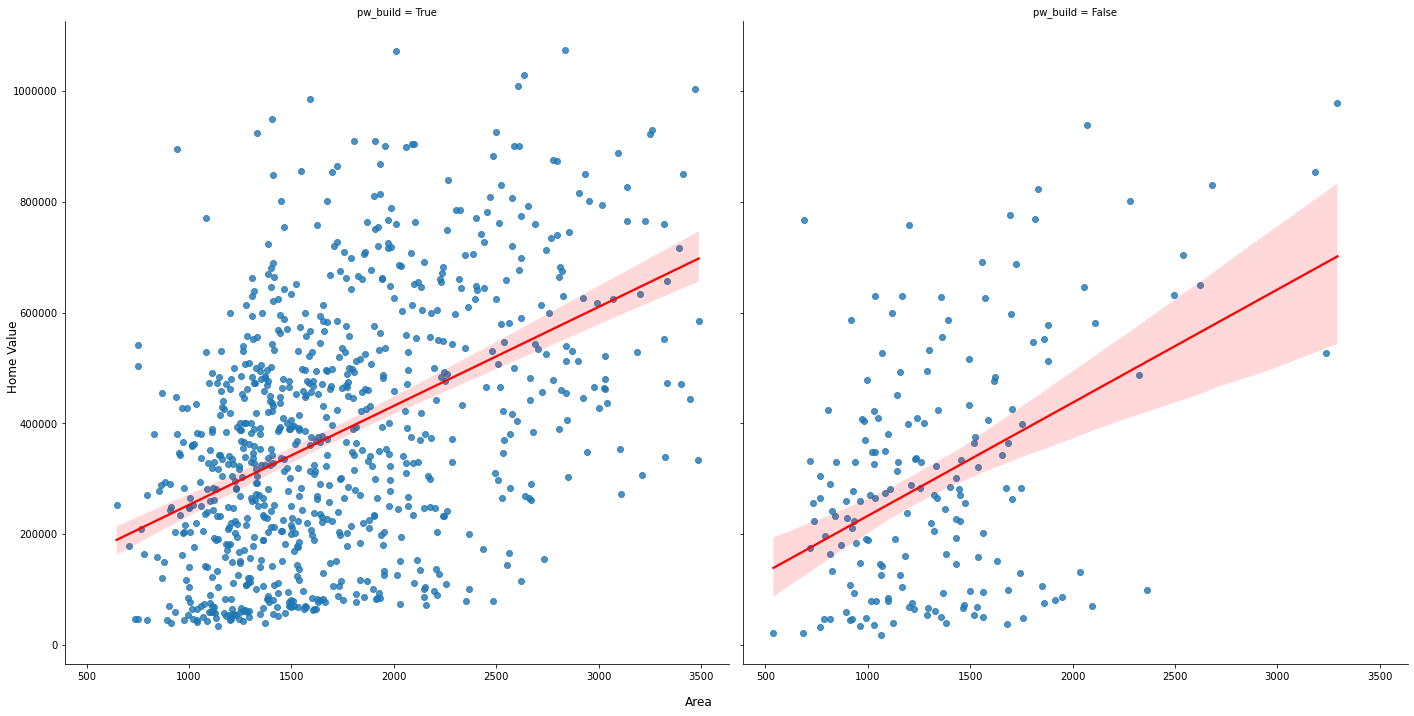

In [99]:
#create lmplot
g = sns.lmplot(x = "area", 
           y = "tax_value", 
           data = train.sample(1000), 
           col = 'pw_build',
           col_order = [True, False],
           size = 10,
           palette = 'husl',
           line_kws = {'color': 'red'})

#remove scientific notation
plt.ticklabel_format(useOffset = False, style = 'plain') 

#set super titles for x and y
g.set_axis_labels('', '') 
g.fig.supxlabel('Area') 
g.fig.supylabel('Home Value')

plt.tight_layout()
plt.show()

In [49]:
#set alpha
α = 0.5

#perform test
r, p_value = pearsonr(train.area, train.tax_value)

#evaluate coefficient and p-value
print(f'Correlation Coefficient: {r}\nP-value: {p_value}')

#evaluate if p < α
if p < α:
    print('Reject the null hypothesis.')
else:
    print('Fail to reject the null hypothesis.')

Correlation Coefficient: 0.415990440840093
P-value: 0.0
Reject the null hypothesis.


#### Takeaways
- Statistically, there is a positive linear relationship between home area and home value. 
    - Visually, the homes that were built pre-war round out with an area at approximately 3000 sqft, while homes built post-war are larger, with more homes at a higher home value.

###  Is there a relationship between the number of bathrooms and homes built after 1945? 

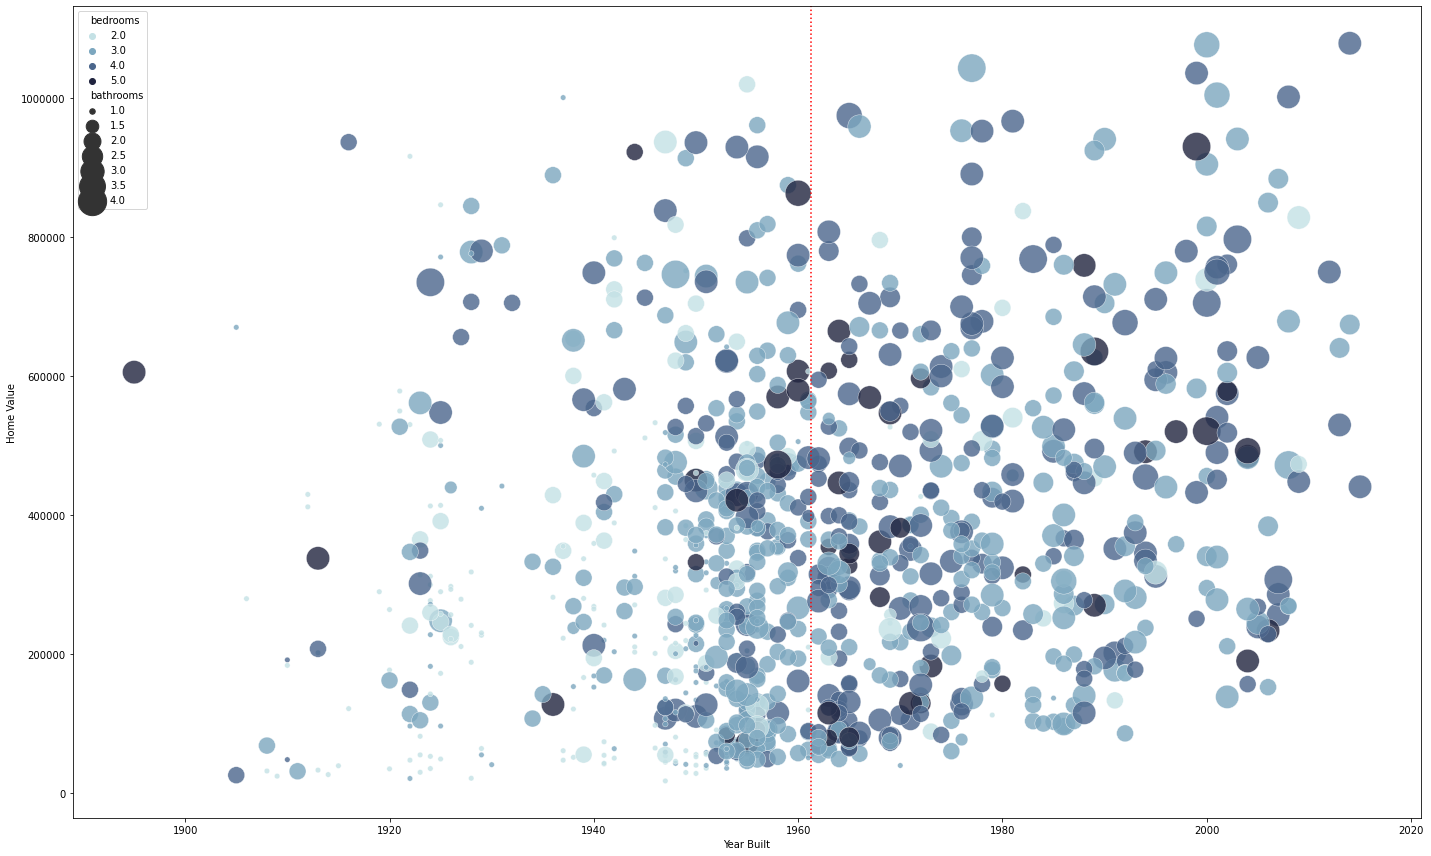

In [68]:
#determine figure size
plt.figure(figsize = (20, 12))

#create colormap
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)

#create vertical line based on mean year_built
plt.axvline(train.year_built.mean(), ls = ':', c = 'r')

#remove scientific notation
plt.ticklabel_format(useOffset = False, style = 'plain') 

#create x, y labels
plt.xlabel('Year Built')
plt.ylabel('Home Value')

#create scatterplot
sns.scatterplot(x = "year_built", y = "tax_value",
                hue = "bedrooms", size = "bathrooms",
                palette = cmap, sizes = (30, 800),
                data = train.sample(1000),
                alpha = 0.8)

#return tight layout
plt.tight_layout()

$Chi^{2}$ Hypothesis

$\alpha$ = .05

$𝐻_{0}$: There is no relationship between the number of bathrooms and homes built after 1945.

𝐻𝑎: There is a relationship between the number of bathrooms and homes built after 1945.

In [50]:
#set alpha
α = 0.5

#setup crosstab of post-war builds and low, medium, and high home values
observed = pd.crosstab(train.bathrooms, train.pw_build)

#perform test
chi2, p, degf, expected = stats.chi2_contingency(observed)
round(p ,3)

#evaluate if p < α
if p < α:
    print('Reject the null hypothesis.')
else:
    print('Fail to reject the null hypothesis.')
   

Reject the null hypothesis.


#### Takeaways:
 - Statistically there is a relationship between homes built after 1945 and the number of bathrooms a home has.
     - The mean home build date in this dataset is 1961, overall, area, bathroom count, and bedroom count appear to increase in tandem.
 

### Visualizing Year Built , Area, and Home Value

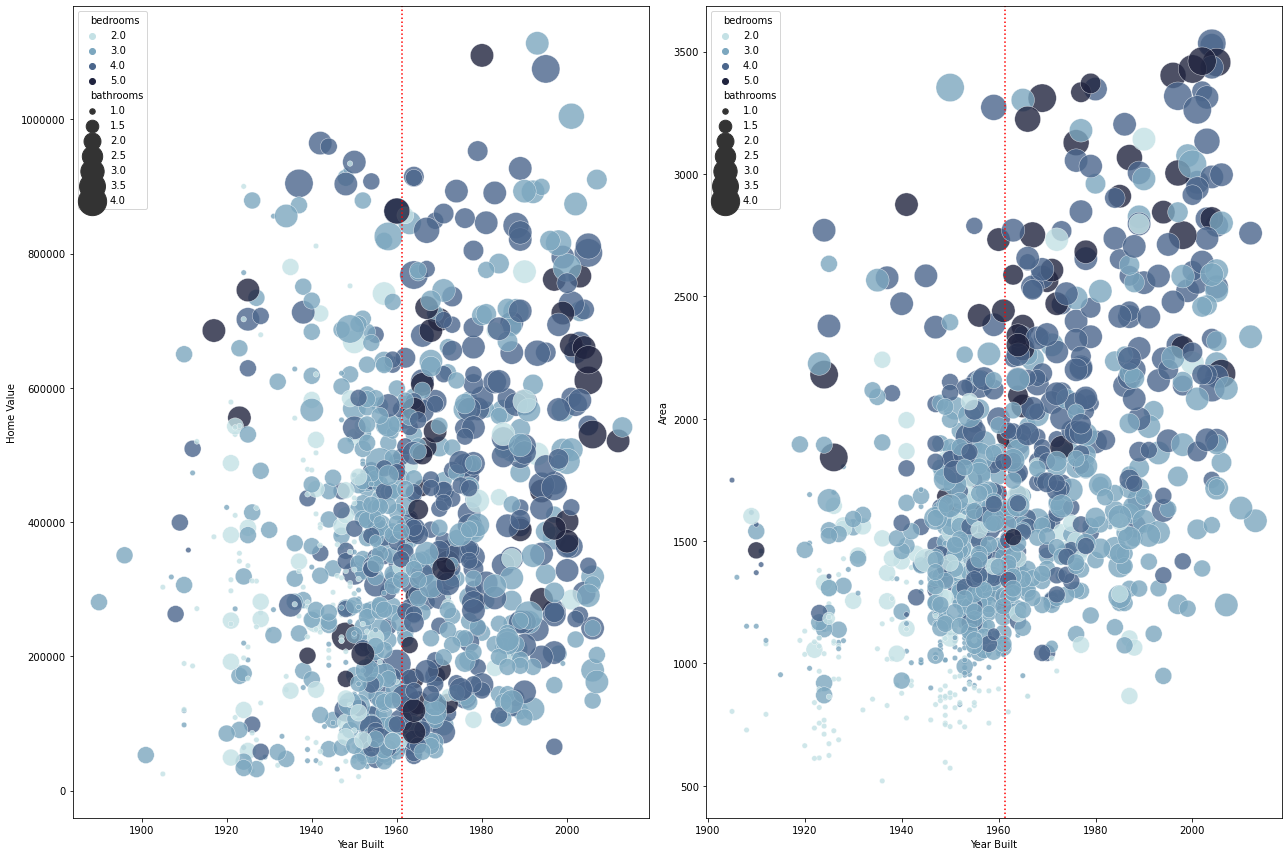

In [100]:
#determine figure size
plt.figure(figsize = (18, 12))

#create subplot 1 row, 2 cols, index 1
plt.subplot(121)

#create colormap
#cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)

#create vertical line based on mean year_built
plt.axvline(train.year_built.mean(), ls = ':', c = 'r')

#remove scientific notation
plt.ticklabel_format(useOffset = False, style = 'plain') 

#create x, y labels
plt.xlabel('Year Built')
plt.ylabel('Home Value')

#create scatterplot
sns.scatterplot(x = "year_built", y = "tax_value",
                hue = "bedrooms", size = "bathrooms",
                palette = cmap, sizes = (30, 800),
                data = train.sample(1000),
                alpha = 0.8)


#create subplot 1 row, 2 cols, index 2
plt.subplot(122)

#create colormap
#cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)

#create vertical line based on mean year_built
plt.axvline(train.year_built.mean(), ls = ':', c = 'r')

#remove scientific notation
plt.ticklabel_format(useOffset = False, style = 'plain') 

#create x, y labels
plt.xlabel('Year Built')
plt.ylabel('Area')

#create scatterplot
sns.scatterplot(x = "year_built", y = "area",
                hue = "bedrooms", size = "bathrooms",
                palette = cmap, sizes = (30, 800),
                data = train.sample(1000),
                alpha = 0.8)



#return tight layout
plt.tight_layout()
plt.show()

#### Takeaways

- Visually, area and home value seem to increase after 1945.
- Bedrooms and bathrooms also show an upward trend in this visualization.
    - Year built, bathroom count, bedroom count, and area all appear to have have some relationship with home value.

### Does Orange County have a Higher than Average Home Value?

One Sample T-Test

$\alpha$ = .05

$𝐻_{0}$: Orange County mean home value is <= than the combined mean home values of Ventura, Los Angeles, and Orange counties.

𝐻𝑎: Orange County mean home value is > than the combined mean home value of Ventura, Los Angeles, and Orange counties.

In [14]:
#set alpha
α = 0.5

#get sample
oc_sample = train[train.county == 'OC'].tax_value

#get mean
overall_mean = train.tax_value.mean()

#perform test
t, p = stats.ttest_1samp(oc_sample, overall_mean)

#evaluate if mean of OC homes is significantly higher than all homes, is p/2 < a and t > 0?
if p/2 < α and t > 0:
    print('Reject the null hypothesis.')
else:
    print('Fail to reject the null hypothesis.')

Reject the null hypothesis.


#### Takeaways
- Orange County homes have a higher home value on average than the mean of the combined counties.
- This may be indicative that mean home prices in Orange County skew the data higher, making a prediction less accurate.
- Separating home values by county is likely to result in further insight.

### Do Homes Near Desirable Areas Have a Higher Value?

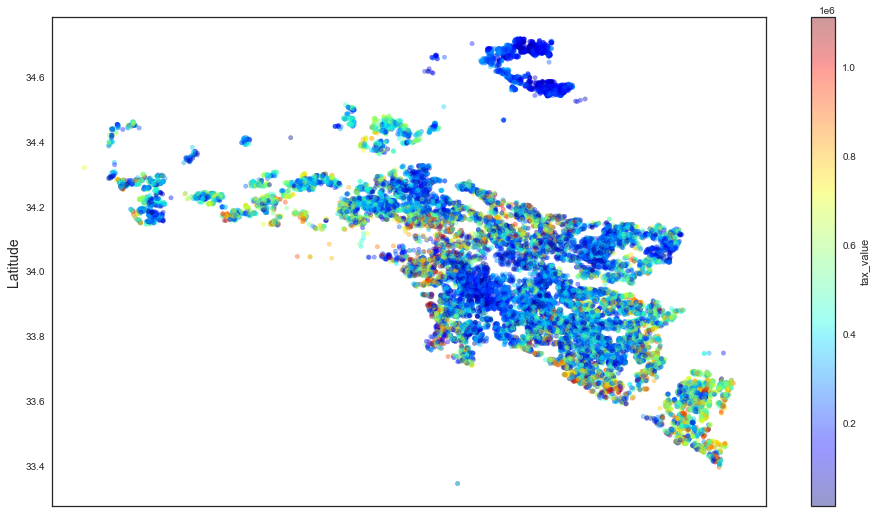

In [95]:
#generate a scatter plot map with the longitude, latitude, and tax_value

train.plot(kind = "scatter", 
        x = "longitude", 
        y = "latitude", 
        c = "tax_value", cmap = plt.get_cmap("jet"),
        colorbar = True,
        alpha = 0.4, 
        figsize = (16, 9))

#sns.despine(left = True, bottom = True)
sns.set_style("white")
plt.ticklabel_format(useOffset = False, style = 'plain') 

plt.show()

<hr style="border-top: 5px groove blanchedalmond; margin-top: 1px; margin-bottom: 1px"></hr>

In [102]:
m = folium.Map(
    location = [train['latitude'].mean(), train['longitude'].mean()],
    zoom_start = 6)
m

#### Takeaways
- Homes with the highest values appear to have adjacent to beaches or mountains
- Feature creation addressing whether or not a home had proximity to beaches and mountains is likely to enhance future predictive models.

### Visualizing Feature Importance

<hr style="border-top: 5px groove blanchedalmond; margin-top: 1px; margin-bottom: 1px"></hr>

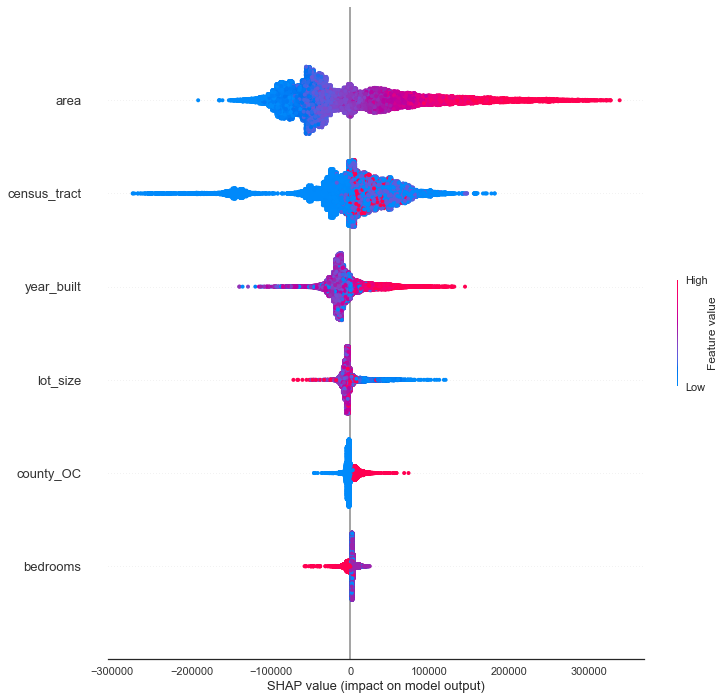

In [123]:
#create model based on RMSE reduction
my_model = XGBRegressor(objective = 'reg:linear',
                      verbosity = 0,
                      n_estimators = 10, 
                      seed = 123).fit(X_train, y_train)
#create feature names
feature_names = X_train.columns

#create model
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_size = [12 ,12])

#### Takeaways
- When fitted to a model based on reducing RMSE, features that are most notable are area, year built, Orange County, and bedrooms.

<hr style="border-top: 10px groove lightsteelblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Modeling and Evaluation

<hr style="border-top: 10px groove lightsteelblue; margin-top: 1px; margin-bottom: 1px"></hr>

#### Baseline

In [21]:
#get baseline, baseline is mean of dependent variable yhat_baseline == baseline

baseline = round(train.tax_value.mean(),2)

print(f' Baseline is: ${baseline}')

 Baseline is: $354603.59


### Multilinear Regression

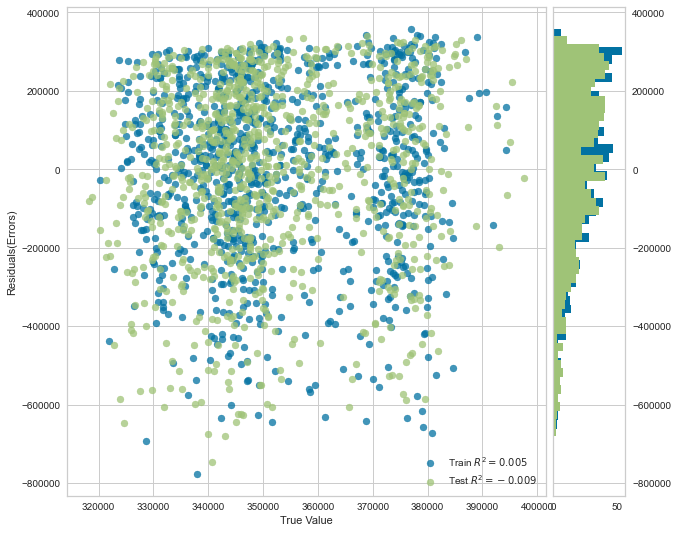

In [66]:
#create X's on scaled data
X_train = train_scaled[['area', 'county_OC', 'year_built', 'bedrooms', 'lot_size', 'census_tract']]
X_validate = validate_scaled[['area', 'county_OC', 'year_built', 'bedrooms', 'lot_size', 'census_tract']]
X_test = test_scaled[['area', 'county_OC', 'year_built', 'bedrooms', 'lot_size', 'census_tract']]

#create y's on unscaled data
y_train = train[['tax_value']]
y_validate = validate[['tax_value']]
y_test = test[['tax_value']]

model = LinearRegression()
plt.figure(figsize = (10, 9))
visualizer = ResidualsPlot(model)
visualizer.fit(X_train.sample(1000), y_train.sample(1000))
visualizer.score(X_validate.sample(1000), y_validate.sample(1000))
model = LinearRegression()

plt.xlabel('True Value')
plt.ylabel('Residuals(Errors)')
plt.legend()
plt.show()

In [67]:
#create X's on scaled data
X_train = train_scaled[['area', 'county_OC', 'year_built', 'bedrooms', 'lot_size', 'census_tract']]
X_validate = validate_scaled[['area', 'county_OC', 'year_built', 'bedrooms', 'lot_size', 'census_tract']]
X_test = test_scaled[['area', 'county_OC', 'year_built', 'bedrooms', 'lot_size', 'census_tract']]

#create y's on unscaled data
y_train = train[['tax_value']]
y_validate = validate[['tax_value']]
y_test = test[['tax_value']]

#create model
lr = LinearRegression(normalize = True)

lr.fit(X_train, y_train)

#make predictions on train (yhat)
y_train_pred = np.round(lr.predict(X_train), 2)

#make predictions on validate(yhat)
y_validate_pred = np.round(lr.predict(X_validate), 2)

#add baseline to train df
y_train['baseline'] = round(y_train['tax_value'].mean(), 2)

#add residual baseline to train df
#residual_baseline = baseline - y_train.target
y_train['residual_baseline'] = y_train.baseline - y_train.tax_value

y_train['predictions_yhat'] = np.round(y_train_pred, 2)


#add baseline to validate df
y_validate['baseline'] = round(y_validate['tax_value'].mean(), 2)

#add residual baseline to train df
#residual_baseline = baseline - y_train.target
y_validate['residual_baseline'] = y_validate.baseline - y_validate.tax_value

#add predictions to df
y_validate['predictions_yhat'] = np.round(y_validate_pred, 2)


#evaluate RMSE on train 

RMSE_train = np.sqrt(mean_squared_error(y_train[['tax_value']], y_train_pred))

#evaluate RMSE on validate

RMSE_validate = np.sqrt(mean_squared_error(y_validate[['tax_value']], y_validate_pred))

#print results
print("RMSE for Multilinear Regression Model\nTraining/In-Sample: ", f'${round(RMSE_train, 2)}', 
      "\nValidation/Out-of-Sample: ", f'${round(RMSE_validate, 2)}')

RMSE for Multilinear Regression Model
Training/In-Sample:  $203023.01 
Validation/Out-of-Sample:  $204512.01


<hr style="border-top: 5px groove blanchedalmond; margin-top: 1px; margin-bottom: 1px"></hr>

### LASSO + LARS

In [98]:
#create X's on scaled data

X_train = train_scaled[['area', 'county_OC', 'year_built', 'bedrooms', 'lot_size', 'census_tract']]
X_validate = validate_scaled[['area', 'county_OC', 'year_built', 'bedrooms', 'lot_size', 'census_tract']]
X_test = test_scaled[['area', 'county_OC', 'year_built', 'bedrooms', 'lot_size', 'census_tract']]

# create y's on unscaled data

y_train = train[['tax_value']]
y_validate = validate[['tax_value']]
y_test = test[['tax_value']]


#create model
lars = LassoLars(alpha = 1)

lars.fit(X_train, y_train)

#make predictions on train (yhat)
y_train_pred = np.round(lars.predict(X_train), 2)

#make predictions on validate(yhat)
y_validate_pred = np.round(lars.predict(X_validate), 2)


#evaluate RMSE on train 

RMSE_train = np.sqrt(mean_squared_error(y_train[['tax_value']], y_train_pred))

#evalue RMSE on validate

RMSE_validate = np.sqrt(mean_squared_error(y_validate[['tax_value']], y_validate_pred))

#print results
print("RMSE for Lasso + Lars Model\nTraining/In-Sample: ", f'${round(RMSE_train, 2)}', 
      "\nValidation/Out-of-Sample: ", f'${round(RMSE_validate, 2)}')

RMSE for Lasso + Lars Model
Training/In-Sample:  $203023.68 
Validation/Out-of-Sample:  $204518.12


<hr style="border-top: 5px groove blanchedalmond; margin-top: 1px; margin-bottom: 1px"></hr>

### Polynomial Regression

In [92]:
#get baseline, baseline is mean of dependent variable yhat_baseline == baseline

baseline = round(train.tax_value.mean(),2)

print(f' Baseline is: ${baseline}')

 Baseline is: $354603.59


In [70]:
#create X's on scaled data

X_train = train_scaled[['area', 'county_OC', 'year_built', 'bedrooms', 'lot_size', 'census_tract']]
X_validate = validate_scaled[['area', 'county_OC', 'year_built', 'bedrooms', 'lot_size', 'census_tract']]
X_test = test_scaled[['area', 'county_OC', 'year_built', 'bedrooms', 'lot_size', 'census_tract']]

# create y's on unscaled data

y_train = train[['tax_value']]
y_validate = validate[['tax_value']]
y_test = test[['tax_value']]


#create converter
pf = PolynomialFeatures(degree = 3)


#fit and transform  on x_scaled
X_train_degree3 = pf.fit_transform(X_train)


#transform X_validate & X_test
X_validate_degree3 = pf.transform(X_validate)

X_test_degree3 = pf.transform(X_test)


#make lr model

lr_p = LinearRegression(normalize = True)

#fit to converted train
lr_p.fit(X_train_degree3, y_train)

#make predictions on train (yhat)
y_train_pred = np.round(lr_p.predict(X_train_degree3), 2)

#make predictions on validate(yhat)
y_validate_pred = np.round(lr_p.predict(X_validate_degree3), 2)


#evaluate RMSE on train 

RMSE_train = np.sqrt(mean_squared_error(y_train[['tax_value']], y_train_pred))

#evalue RMSE on validate

RMSE_validate = np.sqrt(mean_squared_error(y_validate[['tax_value']], y_validate_pred))

#print results
print("RMSE for Polynomial Regression Model\nTraining/In-Sample: ", f'${round(RMSE_train, 2)}', 
      "\nValidation/Out-of-Sample: ", f'${round(RMSE_validate, 2)}')

RMSE for Polynomial Regression Model
Training/In-Sample:  $195762.01 
Validation/Out-of-Sample:  $198302.78


<hr style="border-top: 5px groove blanchedalmond; margin-top: 1px; margin-bottom: 1px"></hr>

In [84]:
#get baseline, baseline is mean of dependent variable yhat_baseline == baseline

baseline = round(train_VC.tax_value.mean(),2)

print(f' The Baseline for Ventura County is: ${baseline}')

 The Baseline for Ventura County is: $399855.06


In [81]:
#create X's on scaled data

X_train = train_scaled_VC[['area', 'county_OC', 'year_built', 'bedrooms', 'lot_size', 'census_tract']]
X_validate = validate_scaled_VC[['area', 'county_OC', 'year_built', 'bedrooms', 'lot_size', 'census_tract']]
X_test = test_scaled_VC[['area', 'county_OC', 'year_built', 'bedrooms', 'lot_size', 'census_tract']]

# create y's on unscaled data

y_train = train_VC[['tax_value']]
y_validate = validate_VC[['tax_value']]
y_test = test_VC[['tax_value']]


#create converter
pf = PolynomialFeatures(degree = 3)


#fit and transform  on x_scaled
X_train_degree3 = pf.fit_transform(X_train)


#transform X_validate & X_test
X_validate_degree3 = pf.transform(X_validate)

X_test_degree3 = pf.transform(X_test)


#make lr model

lr_p = LinearRegression(normalize = True)

#fit to converted train
lr_p.fit(X_train_degree3, y_train)

#make predictions on train (yhat)
y_train_pred = np.round(lr_p.predict(X_train_degree3), 2)

#make predictions on validate(yhat)
y_validate_pred = np.round(lr_p.predict(X_validate_degree3), 2)


#evaluate RMSE on train 

RMSE_train = np.sqrt(mean_squared_error(y_train[['tax_value']], y_train_pred))

#evalue RMSE on validate

RMSE_validate = np.sqrt(mean_squared_error(y_validate[['tax_value']], y_validate_pred))

#print results
print("RMSE for Polynomial Regression Model Ventura County\nTraining/In-Sample: ", f'${round(RMSE_train, 2)}', 
      "\nValidation/Out-of-Sample: ", f'${round(RMSE_validate, 2)}')

RMSE for Polynomial Regression Model Ventura County
Training/In-Sample:  $155373.56 
Validation/Out-of-Sample:  $163100.32


<hr style="border-top: 5px groove blanchedalmond; margin-top: 1px; margin-bottom: 1px"></hr>

In [86]:
#get baseline, baseline is mean of dependent variable yhat_baseline == baseline

baseline = round(train_LA.tax_value.mean(),2)

print(f' The Baseline for Los Angeles County is: ${baseline}')

 The Baseline for Los Angeles County is: $317530.55


In [87]:
#create X's on scaled data

X_train = train_scaled_LA[['area', 'county_OC', 'year_built', 'bedrooms', 'lot_size', 'census_tract']]
X_validate = validate_scaled_LA[['area', 'county_OC', 'year_built', 'bedrooms', 'lot_size', 'census_tract']]
X_test = test_scaled_LA[['area', 'county_OC', 'year_built', 'bedrooms', 'lot_size', 'census_tract']]

# create y's on unscaled data

y_train = train_LA[['tax_value']]
y_validate = validate_LA[['tax_value']]
y_test = test_LA[['tax_value']]


#create converter
pf = PolynomialFeatures(degree = 3)


#fit and transform  on x_scaled
X_train_degree3 = pf.fit_transform(X_train)


#transform X_validate & X_test
X_validate_degree3 = pf.transform(X_validate)

X_test_degree3 = pf.transform(X_test)


#make lr model

lr_p = LinearRegression(normalize = True)

#fit to converted train
lr_p.fit(X_train_degree3, y_train)

#make predictions on train (yhat)
y_train_pred = np.round(lr_p.predict(X_train_degree3), 2)

#make predictions on validate(yhat)
y_validate_pred = np.round(lr_p.predict(X_validate_degree3), 2)


#evaluate RMSE on train 

RMSE_train = np.sqrt(mean_squared_error(y_train[['tax_value']], y_train_pred))

#evalue RMSE on validate

RMSE_validate = np.sqrt(mean_squared_error(y_validate[['tax_value']], y_validate_pred))

#print results
print("RMSE for Polynomial Regression Model Los Angeles County\nTraining/In-Sample: ", f'${round(RMSE_train, 2)}', 
      "\nValidation/Out-of-Sample: ", f'${round(RMSE_validate, 2)}')

RMSE for Polynomial Regression Model Los Angeles County
Training/In-Sample:  $196236.95 
Validation/Out-of-Sample:  $198720.04


<hr style="border-top: 5px groove blanchedalmond; margin-top: 1px; margin-bottom: 1px"></hr>

In [89]:
#get baseline, baseline is mean of dependent variable yhat_baseline == baseline

baseline = round(train_OC.tax_value.mean(),2)

print(f' The Baseline for Orange County is: ${baseline}')

 The Baseline for Orange County is: $431166.85


In [90]:
#create X's on scaled data

X_train = train_scaled_OC[['area', 'county_OC', 'year_built', 'bedrooms', 'lot_size', 'census_tract']]
X_validate = validate_scaled_OC[['area', 'county_OC', 'year_built', 'bedrooms', 'lot_size', 'census_tract']]
X_test = test_scaled_OC[['area', 'county_OC', 'year_built', 'bedrooms', 'lot_size', 'census_tract']]

# create y's on unscaled data

y_train = train_OC[['tax_value']]
y_validate = validate_OC[['tax_value']]
y_test = test_OC[['tax_value']]


#create converter
pf = PolynomialFeatures(degree = 3)


#fit and transform  on x_scaled
X_train_degree3 = pf.fit_transform(X_train)


#transform X_validate & X_test
X_validate_degree3 = pf.transform(X_validate)

X_test_degree3 = pf.transform(X_test)


#make lr model

lr_p = LinearRegression(normalize = True)

#fit to converted train
lr_p.fit(X_train_degree3, y_train)

#make predictions on train (yhat)
y_train_pred = np.round(lr_p.predict(X_train_degree3), 2)

#make predictions on validate(yhat)
y_validate_pred = np.round(lr_p.predict(X_validate_degree3), 2)


#evaluate RMSE on train 

RMSE_train = np.sqrt(mean_squared_error(y_train[['tax_value']], y_train_pred))

#evalue RMSE on validate

RMSE_validate = np.sqrt(mean_squared_error(y_validate[['tax_value']], y_validate_pred))

#print results
print("RMSE for Polynomial Regression Model Orange County\nTraining/In-Sample: ", f'${round(RMSE_train, 2)}', 
      "\nValidation/Out-of-Sample: ", f'${round(RMSE_validate, 2)}')

RMSE for Polynomial Regression Model Orange County
Training/In-Sample:  $293116.26 
Validation/Out-of-Sample:  $295156.11


<hr style="border-top: 10px groove lightsteelblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Model Evaluation on Test

<hr style="border-top: 10px groove lightsteelblue; margin-top: 1px; margin-bottom: 1px"></hr>

In [101]:
#get baseline, baseline is mean of dependent variable yhat_baseline == baseline

baseline = round(train.tax_value.mean(),2)

print(f' Baseline is: ${baseline}')

 Baseline is: $354603.59


In [100]:
#create X's on scaled data

X_train = train_scaled[['area', 'county_OC', 'year_built', 'bedrooms', 'lot_size', 'census_tract']]
X_validate = validate_scaled[['area', 'county_OC', 'year_built', 'bedrooms', 'lot_size', 'census_tract']]
X_test = test_scaled[['area', 'county_OC', 'year_built', 'bedrooms', 'lot_size', 'census_tract']]

# create y's on unscaled data

y_train = train[['tax_value']]
y_validate = validate[['tax_value']]
y_test = test[['tax_value']]


#create converter
pf = PolynomialFeatures(degree = 3)


#fit and transform  on x_scaled
X_train_degree3 = pf.fit_transform(X_train)


#transform X_validate & X_test
X_validate_degree3 = pf.transform(X_validate)

X_test_degree3 = pf.transform(X_test)


#make lr model

lr_p = LinearRegression(normalize = True)

#fit to converted train
lr_p.fit(X_train_degree3, y_train)

#make predictions on train (yhat)
y_train_pred = np.round(lr_p.predict(X_train_degree3), 2)

#make predictions on test(yhat)
y_test_pred = np.round(lr_p.predict(X_test_degree3), 2)


#evaluate RMSE on train 

RMSE_train = np.sqrt(mean_squared_error(y_train[['tax_value']], y_train_pred))

#evalue RMSE on validate

RMSE_test = np.sqrt(mean_squared_error(y_test[['tax_value']], y_test_pred))

#print results
print("RMSE for Polynomial Regression Model\nTraining/In-Sample: ", f'${round(RMSE_train, 2)}', 
      "\nTest/Out-of-Sample: ", f'${round(RMSE_test, 2)}')

RMSE for Polynomial Regression Model
Training/In-Sample:  $195762.01 
Test/Out-of-Sample:  $197230.46


<hr style="border-top: 10px groove lightsteelblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Recommendations

<hr style="border-top: 5px groove blanchedalmond; margin-top: 1px; margin-bottom: 1px"></hr>

- Seperating the data by counties to get a better predictive model was indicative that a more robust dataset with enhanced location information is necessary to gain a better understanding of drivers of home price.
    - Create a new feature that scores proximity to the beach and proximity to the mountains.

# Conclusion and Next Steps

<hr style="border-top: 10px groove lightsteelblue; margin-top: 1px; margin-bottom: 1px"></hr>

#### Location *Matters*

Although the models produced outperform the home value baseline, predictions can be enhanced by improving the quality of the data. Information such as the census tract block and zip codes should provide a better understanding of the predictive patterns of neighborhoods. Given more time, I would like to build better models by removing erroneous zip codes, and create location features such as whether or not a home was adjacent to a key feature likely to drive home price such as the beach or mountains and use provided location features to create a new feature that indicates neighborhood and local schools.
